In [1]:
import numpy as np  #algebra
import pandas as pd  #processamento de dados
import matplotlib.pyplot as plt  #plotagem
import seaborn as sns   #visualizações
sns.set(style="darkgrid")

import sklearn
sklearn.__version__

'0.22.1'

In [111]:
data=pd.read_excel('Bneves1.xlsx')
test_data = pd.read_excel('Bneves_novos1.xlsx')

In [112]:
#data = data.head(10)
data.head()

,Service,Source Port,Source,Destination,Protocol,Action
0,80.0,27147.0,170786933,3574405249,tcp,Drop
1,NaN,NaN,2099066206,3264014475,icmp,Drop
2,80.0,27162.0,170786933,3272084332,tcp,Drop
3,NaN,NaN,234889614,3264014475,icmp,Drop
4,80.0,27297.0,170786933,2728392430,tcp,Drop


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229387 entries, 0 to 229386
Data columns (total 6 columns):
Service        226608 non-null float64
Source Port    226608 non-null float64
Source         229387 non-null int64
Destination    229387 non-null int64
Protocol       229387 non-null object
Action         229387 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 10.5+ MB


In [114]:
# copiar os dados para mais tarde na classificação
train_data = data.copy()
# converter os dados numéricos para categóricos
col_names = list(data) #retirar os nomes dos atributos
for col in col_names:
    data[col] = data[col].astype('category',copy=False)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229387 entries, 0 to 229386
Data columns (total 6 columns):
Service        226608 non-null category
Source Port    226608 non-null category
Source         229387 non-null category
Destination    229387 non-null category
Protocol       229387 non-null category
Action         229387 non-null category
dtypes: category(6)
memory usage: 6.2 MB


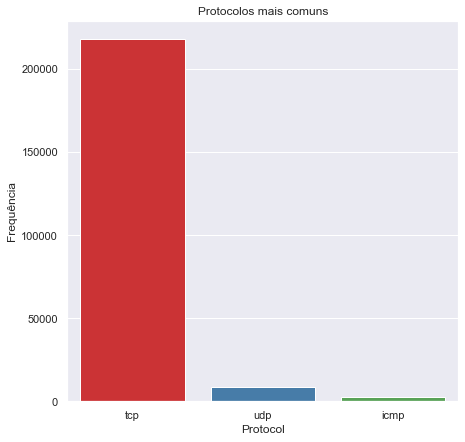

In [115]:
# Protocol bar plot
from collections import Counter
protocol_count = Counter(data.Protocol)
most_protocol = protocol_count.most_common()
protocol_name, count = zip(*most_protocol)
protocol_name, count = list(protocol_name), list(count)

plt.figure(figsize=(7,7))
ax=sns.barplot(x=protocol_name, y=count, palette='Set1')
plt.xlabel('Protocol')
plt.ylabel('Frequência')
plt.title('Protocolos mais comuns')
plt.show()

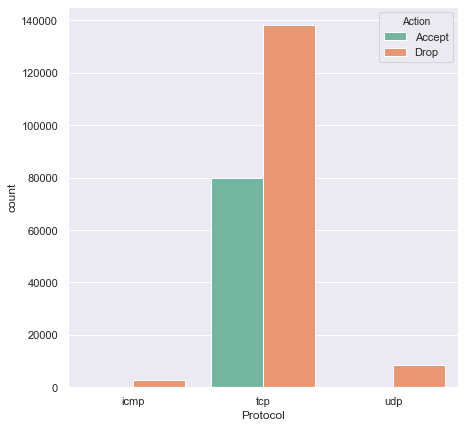

In [116]:
plt.figure(figsize=(7,7))
sns.countplot(x="Protocol", hue="Action", data=data, palette='Set2');

In [117]:
#data['value']=1
#data.columns = ['Service', 'Source Port', 'Source', 'Destination', 'source', 'target', 'value'] # alteração dos nomes das cols

In [118]:
#Sankeychart
#baseado no script em:
#github.com/allisonhonold/floweaver_blog/blob/master/floWeaver_blog.ipynb
#from floweaver import *
#from ipywidgets import *

#nodes = {
#    'start': ProcessGroup(list(data['source'])),
#    'end': ProcessGroup(list(data['target'])),
#}
#ordering = [['start'],['end']]
#bundles = [Bundle('start', 'end')]

#nodes['start'].partition = Partition.Simple('source', data['source'].unique())
#nodes['end'].partition = Partition.Simple('target', data['target'].unique())

#sdd = SankeyDefinition(nodes, bundles, ordering)

#weave(sdd, data).to_widget()

In [119]:
#del data['value'] #só usado uma vez
#data.columns=['Service', 'Source Port', 'Source', 'Destination', 'Protocol', 'Action']
#data.head()

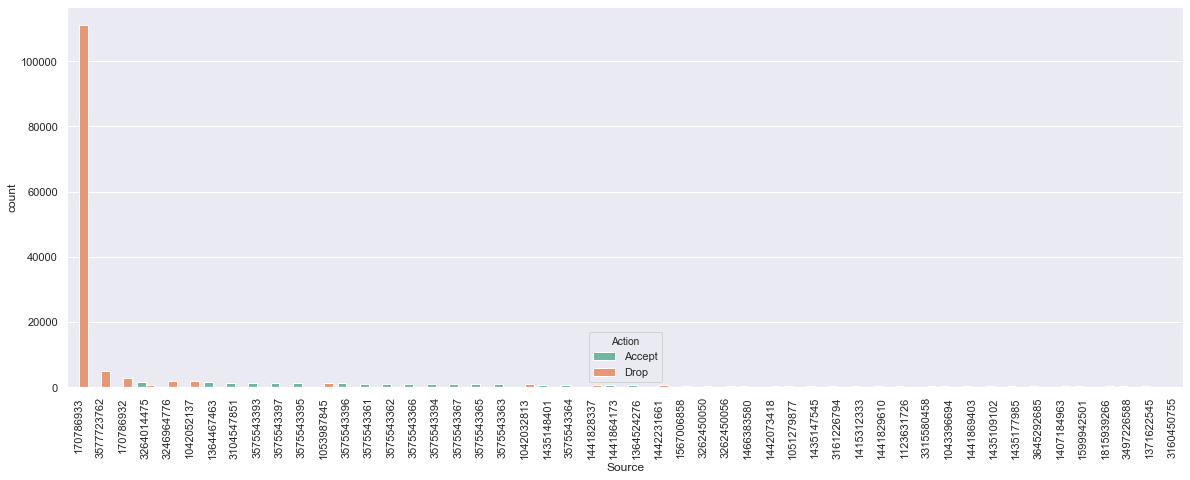

In [120]:
plt.figure(figsize=(20,7))
chart=sns.countplot(x="Source", hue="Action", data=data, palette='Set2', edgecolor=None, order=data.Source.value_counts().iloc[:50].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

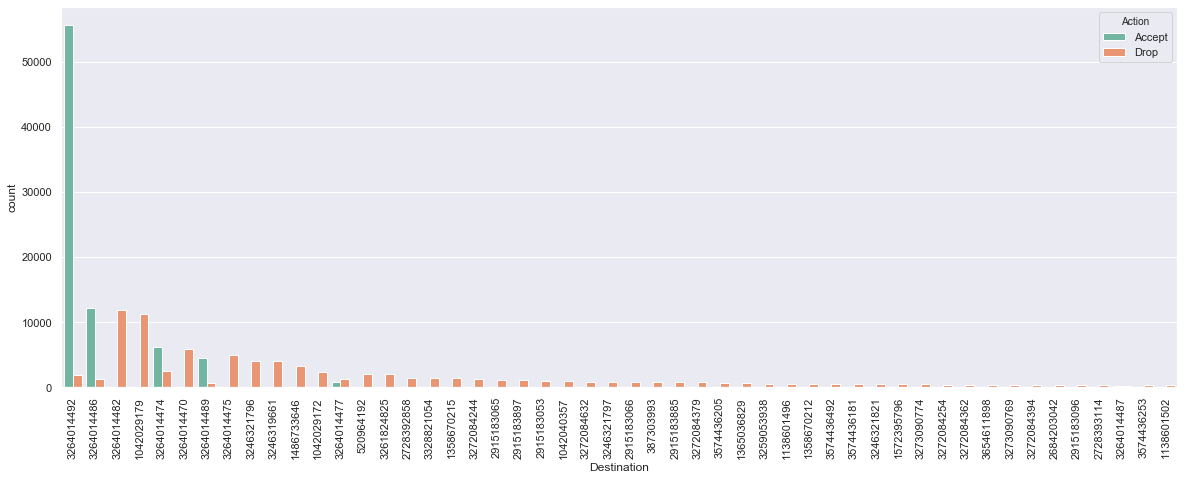

In [121]:
plt.figure(figsize=(20,7))
chart=sns.countplot(x="Destination", hue='Action', data=data, palette='Set2', edgecolor=None, order=data.Destination.value_counts().iloc[:50].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

In [122]:
data_copy = data.copy() #copia dos dados
data_copy.drop(columns=['Action'], inplace=True) #largar a target variable

from sklearn import preprocessing
le = preprocessing.LabelEncoder() #vamos codificar as variáveis categóricas com labels numéricos
data_copy = data_copy.apply(le.fit_transform)
data_copy.head()

,Service,Source Port,Source,Destination,Protocol
0,12,23644,263,3160,1
1,1056,61142,5115,2669,0
2,12,23659,263,2758,1
3,1059,61141,280,2669,0
4,12,23777,263,2090,1


In [123]:
# escolha do número de clusters comparando o cost
# implementação do modelo K-Modes
# implementação baseada no trabalho em:
# kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering
from kmodes.kmodes import KModes
cost=[]
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init='Cao', n_init=1, verbose=1)
    kmode.fit_predict(data_copy)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 625620.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1230, cost: 552194.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1235, cost: 551734.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1236, cost: 546169.0


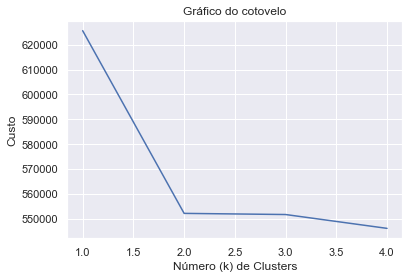

In [124]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost);
plt.title("Gráfico do cotovelo")
plt.ylabel("Custo")
plt.xlabel("Número (k) de Clusters");

In [125]:
# escolhemos k=2
km=KModes(n_clusters=2, init='Cao', n_init=1, verbose=1)
fitClusters=km.fit_predict(data_copy)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1230, cost: 552194.0


In [126]:
data_copy = data.reset_index()

In [127]:
clusters = pd.DataFrame(fitClusters)
clusters.columns = ['predicted_cluster']
combined = pd.concat([data_copy, clusters], axis=1).reset_index()
combined = combined.drop(['index', 'level_0'], axis=1)

In [128]:
combined.head()

,Service,Source Port,Source,Destination,Protocol,Action,predicted_cluster
0,80.0,27147.0,170786933,3574405249,tcp,Drop,0
1,NaN,NaN,2099066206,3264014475,icmp,Drop,0
2,80.0,27162.0,170786933,3272084332,tcp,Drop,0
3,NaN,NaN,234889614,3264014475,icmp,Drop,0
4,80.0,27297.0,170786933,2728392430,tcp,Drop,0


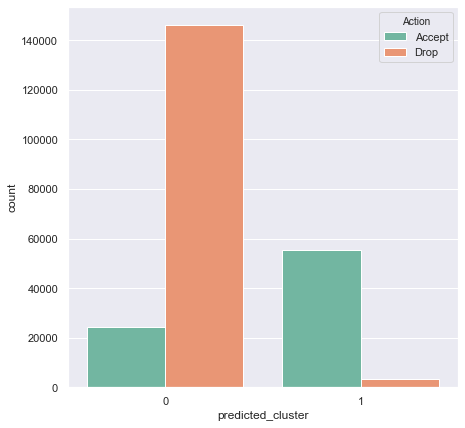

In [129]:
plt.subplots(figsize =(7,7))
sns.countplot(x=combined['predicted_cluster'], order=combined['predicted_cluster'].value_counts().index, hue=combined['Action'], palette='Set2');

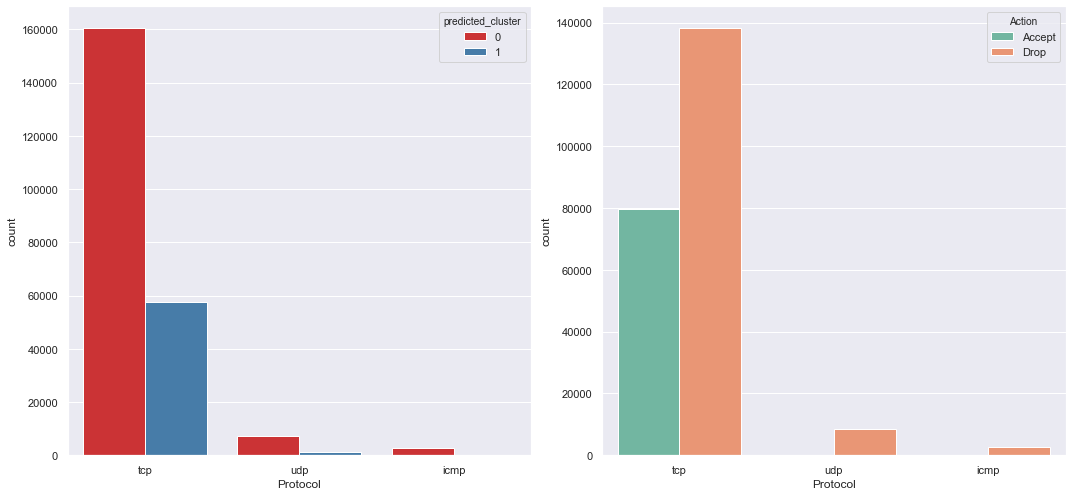

In [130]:
f, axs = plt.subplots(1, 2, figsize =(15,7))
sns.countplot(x=combined['Protocol'], order=combined['Protocol'].value_counts().index, hue=combined['predicted_cluster'], palette='Set1',ax=axs[0]);
sns.countplot(x=combined['Protocol'], order=combined['Protocol'].value_counts().index, hue=combined['Action'], palette='Set2', ax=axs[1]);

plt.tight_layout()
plt.show();

In [131]:
## CLASSIFICAÇÃO

from sklearn.metrics import confusion_matrix, auc, roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
# é necessário fazer o encode das categóricas com labels numéricos para correr os classificadores
from sklearn.preprocessing import LabelEncoder

#boa prática atribuir a cada feature o seu próprio LabelEncoder em vez de fazer o encode à tabela inteira de uma só vez
le_protocol = LabelEncoder()

#fit - ajuste às variáveis, transform - transforma as variáveis nas labels
# muito importante fazer o fit às variáveis de treino para depois transformar a test_data nas labels conformes
train_data['Protocol'] = le_protocol.fit_transform(train_data['Protocol'])
test_data['Protocol'] = le_protocol.transform(test_data['Protocol'])

In [132]:
train_data = train_data.fillna(0)
train_data.head()

,Service,Source Port,Source,Destination,Protocol,Action
0,80.0,27147.0,170786933,3574405249,1,Drop
1,0.0,0.0,2099066206,3264014475,0,Drop
2,80.0,27162.0,170786933,3272084332,1,Drop
3,0.0,0.0,234889614,3264014475,0,Drop
4,80.0,27297.0,170786933,2728392430,1,Drop


In [133]:
# divisão dos dados de treino e teste
from sklearn.model_selection import train_test_split
y = train_data['Action'].values #target variable
X = train_data.drop(['Action'], axis=1).values #atributos

#CLASSIFICAÇÃO DOS DADOS DE TESTE
ytest = test_data['Action'].values #target variable
Xtest = test_data.drop(['Action'], axis=1).values #atributos

In [134]:
# dividimos os dados em 80% treino e 20% teste
# stratify para manter a proporção
#código baseado no trabalho desenvolvido em:
#kaggle.com/lovedeepsaini/fraud-detection-with-naive-bayes-classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [135]:
def get_predictions(classifier, X_train, y_train, X_test, Xtest):
    classifier = classifier 
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test) #previsões de teste
    ypred = classifier.predict(Xtest)
    y_pred_prob = classifier.predict_proba(X_test) #probabilidades previstas
    train_pred = classifier.predict(X_train)
    print('Matriz de confusão (dados de treino):\n', confusion_matrix(y_train, train_pred))
    return y_pred, y_pred_prob, ypred

In [136]:
def print_scores(y_test, y_pred, y_pred_prob, ytest, ypred):
    print('Matriz de confusão (dados de teste):\n', confusion_matrix(y_test, y_pred))
    
    #RECALL SCORE = TP/(TP+FN) é a capacidade do classificador de encontrar os positivos
    print('\nAccept Recall Score: ', recall_score(y_test, y_pred, pos_label='Accept'))
    #RECALL SCORE = TN/(TN+FP) é a capacidade do classificador de encontrar os negativos
    print('Drop Recall Score: ', recall_score(y_test, y_pred, pos_label='Drop'))
    
    #PRECISION SCORE = TP/(TP+FP) é a capacidade de não classificar um positivo como negativo
    print('\nAccept Precision Score: ', precision_score(y_test, y_pred, pos_label='Accept'))
    #PRECISION SCORE = TN/(TN+FN) é a capacidade de não classificar um negativo como positivo
    print('Drop Precision Score: ', precision_score(y_test, y_pred, pos_label='Drop'))
    
    #F1 SCORE = (Precision*Recall)/(Precision + Recall) é a média da Precision e da Recall
    print('\nAccept F1 Score: ', f1_score(y_test, y_pred, pos_label='Accept'))
    print('Drop F1 Score: ', f1_score(y_test, y_pred, pos_label='Drop'))
    
    #ACCURACY = 1-taxa de erro
    print('\nAccuracy: ', accuracy_score(y_test, y_pred))
    #ROC AUC - representa uma medida de separabilidade - o quão capaz é o modelo de distinguir entre as classes
    print('ROC AUC: {}'.format(roc_auc_score(y_test, y_pred_prob[:,1])))
    
    print('\nDADOS DE TESTE\n')
    print('Matriz de confusão:\n', confusion_matrix(ytest, ypred))
    print('\nAccuracy:', accuracy_score(ytest, ypred))
    print(ypred)

In [137]:
from sklearn.naive_bayes import MultinomialNB ##só disponível com a versão 22.1 do sklearn

y_pred, y_pred_prob, ypred = get_predictions(MultinomialNB(), X_train, y_train, X_test, Xtest)
print_scores(y_test, y_pred, y_pred_prob, ytest, ypred)

Matriz de confusão (dados de treino):
 [[54420  9405]
 [23681 96003]]
Matriz de confusão (dados de teste):
 [[13643  2314]
 [ 5910 24011]]

Accept Recall Score:  0.8549852729209751
Drop Recall Score:  0.802479863640921

Accept Precision Score:  0.6977445916227689
Drop Precision Score:  0.9120987654320988

Accept F1 Score:  0.7684032666854409
Drop F1 Score:  0.8537851580556839

Accuracy:  0.820741967827717
ROC AUC: 0.8287325682809481

DADOS DE TESTE

Matriz de confusão:
 [[10 10]
 [ 0  0]]

Accuracy: 0.5
['Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Accept' 'Drop' 'Drop' 'Accept'
 'Accept' 'Drop' 'Drop' 'Drop' 'Drop' 'Accept' 'Drop' 'Accept' 'Accept'
 'Accept' 'Drop']


In [138]:
from sklearn.tree import DecisionTreeClassifier

y_pred, y_pred_prob, ypred = get_predictions(DecisionTreeClassifier(criterion = 'entropy',
                                                                    max_depth=17, 
                                                                    min_samples_split=13, 
                                                                    min_samples_leaf=1), X_train, y_train, X_test, Xtest)
print_scores(y_test, y_pred, y_pred_prob, ytest, ypred)

Matriz de confusão (dados de treino):
 [[ 63685    140]
 [  1135 118549]]
Matriz de confusão (dados de teste):
 [[15858    99]
 [  330 29591]]

Accept Recall Score:  0.9937958262831359
Drop Recall Score:  0.9889709568530464

Accept Precision Score:  0.9796145292809488
Drop Precision Score:  0.9966655439541934

Accept F1 Score:  0.9866542230517966
Drop F1 Score:  0.992803341665129

Accuracy:  0.9906491128645538
ROC AUC: 0.9961810277456482

DADOS DE TESTE

Matriz de confusão:
 [[12  8]
 [ 0  0]]

Accuracy: 0.6
['Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Accept' 'Accept' 'Drop' 'Drop'
 'Accept' 'Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Drop' 'Accept'
 'Accept' 'Accept' 'Drop']


In [139]:
from sklearn.neighbors import KNeighborsClassifier

y_pred, y_pred_prob, ypred = get_predictions(KNeighborsClassifier(n_neighbors=4, weights='distance'), X_train, y_train, X_test, Xtest)
print_scores(y_test, y_pred, y_pred_prob, ytest, ypred)

Matriz de confusão (dados de treino):
 [[ 63760     65]
 [   584 119100]]
Matriz de confusão (dados de teste):
 [[15633   324]
 [  383 29538]]

Accept Recall Score:  0.9796954314720813
Drop Recall Score:  0.9871996256809599

Accept Precision Score:  0.9760864135864136
Drop Precision Score:  0.9891500904159132

Accept F1 Score:  0.9778875926563039
Drop F1 Score:  0.9881738955890471

Accuracy:  0.9845895636252671
ROC AUC: 0.9898609653077014

DADOS DE TESTE

Matriz de confusão:
 [[12  8]
 [ 0  0]]

Accuracy: 0.6
['Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Accept' 'Accept' 'Drop' 'Drop'
 'Accept' 'Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Drop' 'Accept'
 'Accept' 'Accept' 'Drop']


In [144]:
# Otimização de parâmetros da rede neuronal
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid

In [162]:
def create_model(layers, activation):
    rede_neuronal = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            rede_neuronal.add(Dense(nodes, input_dim = X_train.shape[1]))
            rede_neuronal.add(Activation(activation))
            rede_neuronal.add(Dropout(0.3))
        else:
            rede_neuronal.add(Dense(nodes))
            rede_neuronal.add(Activation(activation))
            rede_neuronal.add(Dropout(0.3))
        
    rede_neuronal.add(Dense(units = 1, kernel_initializer = 'glorot_uniform', activation='sigmoid'))
    rede_neuronal.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rede_neuronal

In [163]:
rede_neuronal = KerasClassifier(build_fn=create_model, verbose=1)

In [188]:
#layers=[[20], [40,20], [45, 30, 15]]
layers = [(30, 30), (50, 30, 50)]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation = activations, batch_size = [128, 256], epochs=[10])
grid = GridSearchCV(estimator=rede_neuronal, param_grid=param_grid, 
                    cv=3)

In [189]:
grid_result=grid.fit(X_train, y_train)

Epoch 1/10
122339/122339 [==============================] - 2s 19us/step - loss: 0.5550 - accuracy: 0.7054
Epoch 2/10
122339/122339 [==============================] - 2s 16us/step - loss: 0.5005 - accuracy: 0.7413
Epoch 3/10
122339/122339 [==============================] - 2s 16us/step - loss: 0.4937 - accuracy: 0.7477
Epoch 4/10
122339/122339 [==============================] - 2s 17us/step - loss: 0.4941 - accuracy: 0.7491
Epoch 5/10
122339/122339 [==============================] - 2s 18us/step - loss: 0.4918 - accuracy: 0.7538
Epoch 6/10
122339/122339 [==============================] - 3s 22us/step - loss: 0.4900 - accuracy: 0.7538
Epoch 7/10
122339/122339 [==============================] - 2s 19us/step - loss: 0.4880 - accuracy: 0.7553
Epoch 8/10
122339/122339 [==============================] - 2s 19us/step - loss: 0.4888 - accuracy: 0.7538
Epoch 9/10
122339/122339 [==============================] - 2s 18us/step - loss: 0.4877 - accuracy: 0.7550
Epoch 10/10
61170/61170 [============

In [190]:
print(grid_result.best_score_, grid_result.best_params_)

0.8194584846496582 {'activation': 'sigmoid', 'batch_size': 128, 'epochs': 10, 'layers': (50, 30, 50)}


In [191]:
y_pred = grid.predict(X_test) #previsões de teste
ypred = grid.predict(Xtest)
y_pred_prob = grid.predict_proba(X_test) #probabilidades previstas
print_scores(y_test, y_pred, y_pred_prob, ytest, ypred)

45878/45878 [==============================] - 0s 6us/step
Matriz de confusão (dados de teste):
 [[15378   579]
 [ 8366 21555]]

Accept Recall Score:  0.9637149840195526
Drop Recall Score:  0.7203970455532903

Accept Precision Score:  0.6476583557951483
Drop Precision Score:  0.973841149362971

Accept F1 Score:  0.7746908138334048
Drop F1 Score:  0.8281625204111036

Accuracy:  0.8050263742970487
ROC AUC: 0.8613804019528379

DADOS DE TESTE

Matriz de confusão:
 [[12  8]
 [ 0  0]]

Accuracy: 0.6
[['Drop']
 ['Drop']
 ['Accept']
 ['Accept']
 ['Accept']
 ['Accept']
 ['Drop']
 ['Drop']
 ['Accept']
 ['Accept']
 ['Drop']
 ['Drop']
 ['Accept']
 ['Accept']
 ['Accept']
 ['Drop']
 ['Accept']
 ['Accept']
 ['Accept']
 ['Drop']]


In [231]:
# Modelo Ensemble AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

y_pred, y_pred_prob, ypred = get_predictions(AdaBoostClassifier(DecisionTreeClassifier(criterion = 'entropy',
                                                                                       max_depth=7, 
                                                                                       min_samples_split=12, 
                                                                                       min_samples_leaf=1), 
                                                                n_estimators=25), 
                                             X_train, y_train, X_test, Xtest)
print_scores(y_test, y_pred, y_pred_prob, ytest, ypred)

Matriz de confusão (dados de treino):
 [[ 63617    208]
 [  1003 118681]]
Matriz de confusão (dados de teste):
 [[15839   118]
 [  319 29602]]

Accept Recall Score:  0.992605126276869
Drop Recall Score:  0.9893385916246115

Accept Precision Score:  0.9802574576061394
Drop Precision Score:  0.9960296096904442

Accept F1 Score:  0.9863926514089989
Drop F1 Score:  0.9926728257406818

Accuracy:  0.9904747373468765
ROC AUC: 0.9977001835023787

DADOS DE TESTE

Matriz de confusão:
 [[12  8]
 [ 0  0]]

Accuracy: 0.6
['Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Accept' 'Accept' 'Drop' 'Drop'
 'Accept' 'Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Drop' 'Accept'
 'Accept' 'Accept' 'Drop']


In [232]:
# Importância relativa dos atributos?
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [233]:
def select_features(X_train, y_train, X_test, Xtest,  k):
    fs = SelectKBest(score_func=chi2, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    Xtest_fs = fs.transform(Xtest)
    return X_train_fs, X_test_fs, Xtest_fs, fs

Feature 0: 61370295.155641
Feature 1: 145679147.736697
Feature 2: 76014812602458.187500
Feature 3: 9597847622976.796875
Feature 4: 58.171967


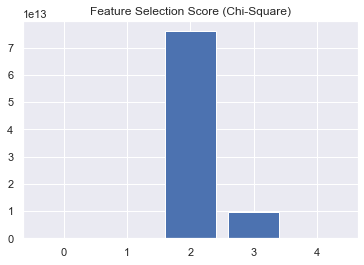

In [234]:
X_train_fs, X_test_fs, Xtest_fs, fs = select_features(X_train, y_train, X_test, Xtest, k='all')

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Feature Selection Score (Chi-Square)')
plt.show()

In [235]:
# Selecionamos então apenas as 2 variáveis

X_train_fs, X_test_fs, Xtest_fs, fs = select_features(X_train, y_train, X_test, Xtest, k=2)

In [251]:
y_pred, y_pred_prob, ypred = get_predictions(AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',
                                                                   max_depth=10,
                                                                   min_samples_split=12,
                                                                   min_samples_leaf=1), 
                                                                n_estimators=200),
                                             X_train_fs, y_train, X_test_fs, Xtest_fs)
print_scores(y_test, y_pred, y_pred_prob, ytest, ypred)

Matriz de confusão (dados de treino):
 [[ 63493    332]
 [  2193 117491]]
Matriz de confusão (dados de teste):
 [[15762   195]
 [  692 29229]]

Accept Recall Score:  0.9877796578304192
Drop Recall Score:  0.9768724307342669

Accept Precision Score:  0.9579433572383615
Drop Precision Score:  0.9933727569331158

Accept F1 Score:  0.9726327481410632
Drop F1 Score:  0.9850535007161513

Accuracy:  0.9806661144775274
ROC AUC: 0.9948555312553888

DADOS DE TESTE

Matriz de confusão:
 [[12  8]
 [ 0  0]]

Accuracy: 0.6
['Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Accept' 'Accept' 'Drop' 'Drop'
 'Accept' 'Drop' 'Drop' 'Accept' 'Accept' 'Accept' 'Drop' 'Accept'
 'Accept' 'Accept' 'Drop']
